In [1]:
import numpy as np
from glob import glob
from matplotlib import pyplot
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize_with_crop_or_pad(img, IMG_H, IMG_W)
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    return img

def tf_dataset(images_path, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(images_path)
    dataset = dataset.shuffle(buffer_size=10240)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [4]:
batch_size = 10
latent_dim = 128
num_epochs = 1000
IMG_H = 64
IMG_W = 64
IMG_C = 3

images_path = glob('/content/drive/MyDrive/Colab Notebooks/DL Project/data/*')
images_dataset = tf_dataset(images_path, batch_size)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

## Generator

In [5]:
def build_generator(latent_dim):
    
    filters = 32
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(16 * filters * h_output * w_output, use_bias=False, input_shape=(latent_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((h_output, w_output, 16 * filters)))
    
    #DeConv2D
    model.add(Conv2DTranspose(
        filters=256,
        kernel_size=5,
        kernel_initializer=w_init,
        padding="same",
        strides=2))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
              
    model.add(Conv2DTranspose(
        filters=128,
        kernel_size=5,
        kernel_initializer=w_init,
        padding="same",
        strides=2))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
              
    model.add(Conv2DTranspose(
        filters=64,
        kernel_size=5,
        kernel_initializer=w_init,
        padding="same",
        strides=2))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
              
    model.add(Conv2DTranspose(
        filters=32,
        kernel_size=5,
        kernel_initializer=w_init,
        padding="same",
        strides=2))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
              
    #Conv
    model.add(Conv2D(
        filters=3,
        kernel_size=5,
        kernel_initializer=w_init,
        padding='same',
        strides=1))
    model.add(Activation("tanh"))
              
    return model

In [6]:
# generator optimization function
generator = build_generator(latent_dim)
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

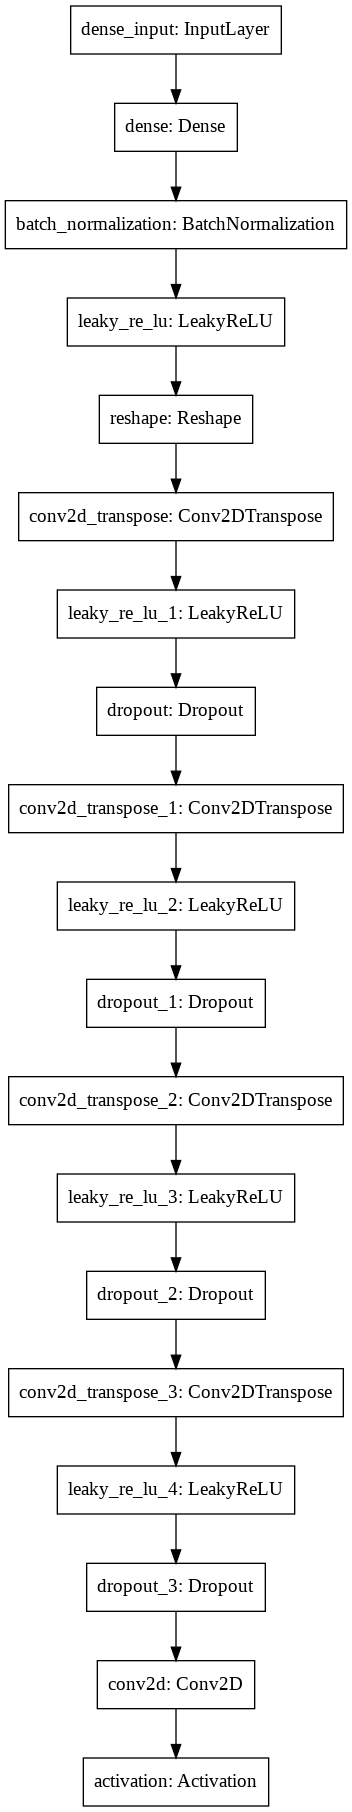

In [8]:
tf.keras.utils.plot_model(generator, to_file='generator.png')

## Discriminator

In [9]:
def build_discriminator():
    
    filters = 64
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides
    
    model = tf.keras.Sequential()
    model.add(Input(shape=(IMG_H, IMG_W, IMG_C)))
    
    model.add(Conv2D(
        filters=256,
        kernel_size=5,
        kernel_initializer=w_init,
        padding='same',
        strides=2))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(
        filters=128,
        kernel_size=5,
        kernel_initializer=w_init,
        padding='same',
        strides=2))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(
        filters=32,
        kernel_size=5,
        kernel_initializer=w_init,
        padding='same',
        strides=2))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(
        filters=64,
        kernel_size=5,
        kernel_initializer=w_init,
        padding='same',
        strides=2))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(1))
    
    return model

In [10]:
discriminator = build_discriminator()
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

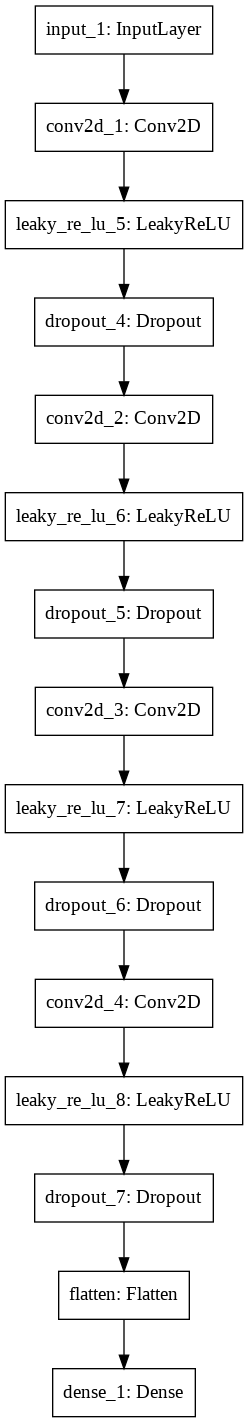

In [11]:
tf.keras.utils.plot_model(discriminator, to_file='discriminator.png')

## Train

In [12]:
def gan(real_images):
        batch_size = tf.shape(real_images)[0]

        for _ in range(2):
            ## Train the discriminator
            random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
            generated_images = generator(random_latent_vectors)
            generated_labels = tf.zeros((batch_size, 1))

            with tf.GradientTape() as ftape:
                predictions = discriminator(generated_images)
                d1_loss = cross_entropy(generated_labels, predictions)
            grads = ftape.gradient(d1_loss, discriminator.trainable_weights)
            discriminator_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

            ## Train the discriminator
            labels = tf.ones((batch_size, 1))

            with tf.GradientTape() as rtape:
                predictions = discriminator(real_images)
                d2_loss = cross_entropy(labels, predictions)
            grads = rtape.gradient(d2_loss, discriminator.trainable_weights)
            discriminator_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

        ## Train the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as gtape:
            predictions = discriminator(generator(random_latent_vectors))
            g_loss = cross_entropy(misleading_labels, predictions)
        grads = gtape.gradient(g_loss, generator.trainable_weights)
        generator_optimizer.apply_gradients(zip(grads, generator.trainable_weights))

        return {"d1_loss": d1_loss, "d2_loss": d2_loss, "g_loss": g_loss}

In [14]:
def train(images_dataset, num_epochs):
    for epoch in range(num_epochs):
        for image in images_dataset:
            vals = gan(image)
        print('epoch:', epoch, 'Discriminator loss:', vals['d1_loss']+vals['d2_loss'], 'Generator loss:', vals['g_loss'])

In [15]:
train(images_dataset, 100)

epoch: 0 Discriminator loss: tf.Tensor(0.4228749, shape=(), dtype=float32) Generator loss: tf.Tensor(3.707615, shape=(), dtype=float32)
epoch: 1 Discriminator loss: tf.Tensor(0.41889036, shape=(), dtype=float32) Generator loss: tf.Tensor(2.542191, shape=(), dtype=float32)
epoch: 2 Discriminator loss: tf.Tensor(0.40782484, shape=(), dtype=float32) Generator loss: tf.Tensor(2.9170244, shape=(), dtype=float32)
epoch: 3 Discriminator loss: tf.Tensor(0.4263615, shape=(), dtype=float32) Generator loss: tf.Tensor(2.5499694, shape=(), dtype=float32)
epoch: 4 Discriminator loss: tf.Tensor(0.40823197, shape=(), dtype=float32) Generator loss: tf.Tensor(2.9769175, shape=(), dtype=float32)
epoch: 5 Discriminator loss: tf.Tensor(0.43866473, shape=(), dtype=float32) Generator loss: tf.Tensor(3.332047, shape=(), dtype=float32)
epoch: 6 Discriminator loss: tf.Tensor(0.42334813, shape=(), dtype=float32) Generator loss: tf.Tensor(3.9749637, shape=(), dtype=float32)
epoch: 7 Discriminator loss: tf.Tensor(

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


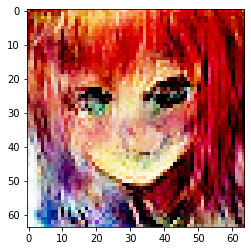

In [16]:
pyplot.imshow(tf.reshape(generator(np.random.randn(1, latent_dim)), (64, 64, 3)))

## Evaluation with FID Score

In [18]:
def resize_and_preprocess(image):

    # resize the image to the expected input size for inception model
    image = tf.image.resize(image, (299,299), method='nearest')

    # preprocess image requied by inception model
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.inception_v3.preprocess_input(image)

    return image

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize_with_crop_or_pad(img, IMG_H, IMG_W)
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    return img

def tf_dataset(images_path):
    dataset = tf.data.Dataset.from_tensor_slices(images_path)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

images_path = glob('/content/drive/MyDrive/Colab Notebooks/DL Project/data/*')
images_dataset = tf_dataset(images_path)

trainloader = (
    images_dataset
    .shuffle(1024)
    .map(resize_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(5)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [19]:
def generate_images(l, model):
    # generate images using the trained generator
    noise = tf.random.normal([batch_size, latent_dim])
    images = generator(noise)

    # prepare the images for resize_and_preprocess function
    #images = tf.squeeze(images, axis=-1)
    images = images*0.5+0.5
    images = tf.image.convert_image_dtype(images, dtype=tf.uint8)

    return images

genloader = tf.data.Dataset.from_tensors([1])

genloader = (
    genloader
    .map(lambda x: generate_images(x, generator), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(resize_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [20]:
from tqdm import tqdm

def compute_embeddings(dataloader, count):
    image_embeddings = []

    for _ in tqdm(range(count)):
        images = next(iter(dataloader))
        print(images.shape)
        embeddings = inception_model.predict(images)

        image_embeddings.extend(embeddings)

    return np.array(image_embeddings)



In [21]:
tf.keras.backend.clear_session()
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

inception_model = InceptionV3(include_top=False, 
                              pooling='avg',
                              input_shape=(299, 299, 3))

87916544/87910968 [==============================] - 1s 0us/step


In [22]:
import math

count = 25

# compute embeddings for real images
real_image_embeddings = compute_embeddings(trainloader, count)

# compute embeddings for generated images
generated_image_embeddings = compute_embeddings(genloader, count)

real_image_embeddings.shape, generated_image_embeddings.shape

  0%|          | 0/25 [00:00<?, ?it/s]

(5, 299, 299, 3)


  8%|▊         | 2/25 [00:04<01:00,  2.63s/it]

(5, 299, 299, 3)


 12%|█▏        | 3/25 [00:05<00:47,  2.17s/it]

(5, 299, 299, 3)


 16%|█▌        | 4/25 [00:06<00:38,  1.84s/it]

(5, 299, 299, 3)


 20%|██        | 5/25 [00:07<00:32,  1.60s/it]

(5, 299, 299, 3)


 24%|██▍       | 6/25 [00:08<00:27,  1.46s/it]

(5, 299, 299, 3)


 28%|██▊       | 7/25 [00:09<00:24,  1.34s/it]

(5, 299, 299, 3)


 32%|███▏      | 8/25 [00:10<00:21,  1.25s/it]

(5, 299, 299, 3)


 36%|███▌      | 9/25 [00:11<00:19,  1.20s/it]

(5, 299, 299, 3)


 40%|████      | 10/25 [00:12<00:17,  1.17s/it]

(5, 299, 299, 3)


 44%|████▍     | 11/25 [00:14<00:16,  1.15s/it]

(5, 299, 299, 3)


 48%|████▊     | 12/25 [00:15<00:14,  1.13s/it]

(5, 299, 299, 3)


 52%|█████▏    | 13/25 [00:16<00:13,  1.11s/it]

(5, 299, 299, 3)


 56%|█████▌    | 14/25 [00:17<00:12,  1.09s/it]

(5, 299, 299, 3)


 60%|██████    | 15/25 [00:18<00:10,  1.10s/it]

(5, 299, 299, 3)


 64%|██████▍   | 16/25 [00:19<00:09,  1.09s/it]

(5, 299, 299, 3)


 68%|██████▊   | 17/25 [00:20<00:08,  1.08s/it]

(5, 299, 299, 3)


 72%|███████▏  | 18/25 [00:21<00:07,  1.08s/it]

(5, 299, 299, 3)


 76%|███████▌  | 19/25 [00:22<00:06,  1.07s/it]

(5, 299, 299, 3)


 80%|████████  | 20/25 [00:23<00:05,  1.07s/it]

(5, 299, 299, 3)


 84%|████████▍ | 21/25 [00:24<00:04,  1.07s/it]

(5, 299, 299, 3)


 88%|████████▊ | 22/25 [00:25<00:03,  1.06s/it]

(5, 299, 299, 3)


 92%|█████████▏| 23/25 [00:26<00:02,  1.07s/it]

(5, 299, 299, 3)


 96%|█████████▌| 24/25 [00:27<00:01,  1.06s/it]

(5, 299, 299, 3)


  0%|          | 0/25 [00:00<?, ?it/s]

(5, 299, 299, 3)
(10, 299, 299, 3)


  8%|▊         | 2/25 [00:02<00:39,  1.71s/it]

(10, 299, 299, 3)


 12%|█▏        | 3/25 [00:03<00:30,  1.39s/it]

(10, 299, 299, 3)


 16%|█▌        | 4/25 [00:04<00:24,  1.18s/it]

(10, 299, 299, 3)


 20%|██        | 5/25 [00:04<00:20,  1.03s/it]

(10, 299, 299, 3)


 24%|██▍       | 6/25 [00:05<00:17,  1.07it/s]

(10, 299, 299, 3)


 28%|██▊       | 7/25 [00:06<00:15,  1.17it/s]

(10, 299, 299, 3)


 32%|███▏      | 8/25 [00:06<00:13,  1.25it/s]

(10, 299, 299, 3)


 36%|███▌      | 9/25 [00:07<00:12,  1.29it/s]

(10, 299, 299, 3)


 40%|████      | 10/25 [00:08<00:11,  1.34it/s]

(10, 299, 299, 3)


 44%|████▍     | 11/25 [00:08<00:10,  1.38it/s]

(10, 299, 299, 3)


 48%|████▊     | 12/25 [00:09<00:09,  1.40it/s]

(10, 299, 299, 3)


 52%|█████▏    | 13/25 [00:10<00:09,  1.32it/s]

(10, 299, 299, 3)


 56%|█████▌    | 14/25 [00:11<00:08,  1.35it/s]

(10, 299, 299, 3)


 60%|██████    | 15/25 [00:11<00:07,  1.38it/s]

(10, 299, 299, 3)


 64%|██████▍   | 16/25 [00:12<00:06,  1.36it/s]

(10, 299, 299, 3)


 68%|██████▊   | 17/25 [00:13<00:05,  1.40it/s]

(10, 299, 299, 3)


 72%|███████▏  | 18/25 [00:14<00:04,  1.41it/s]

(10, 299, 299, 3)


 76%|███████▌  | 19/25 [00:14<00:04,  1.44it/s]

(10, 299, 299, 3)


 80%|████████  | 20/25 [00:15<00:03,  1.47it/s]

(10, 299, 299, 3)


 84%|████████▍ | 21/25 [00:16<00:02,  1.43it/s]

(10, 299, 299, 3)


 88%|████████▊ | 22/25 [00:16<00:02,  1.38it/s]

(10, 299, 299, 3)


 92%|█████████▏| 23/25 [00:17<00:01,  1.41it/s]

(10, 299, 299, 3)


 96%|█████████▌| 24/25 [00:18<00:00,  1.42it/s]

(10, 299, 299, 3)


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]

(10, 299, 299, 3)


((125, 2048), (250, 2048))

In [23]:
from scipy import linalg

def calculate_fid(real_embeddings, generated_embeddings):
    # calculate mean and covariance statistics
    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
    mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
      covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [24]:
fid = calculate_fid(real_image_embeddings, generated_image_embeddings)

print('The computed FID score is: ', fid)

The computed FID score is:  474.0227204571863
